# Capstone Project SkimLit:
The purpose of this notebook is to build an NLP model to improve readability of medical abstracts.

The data set source is: https://arxiv.org/abs/1710.06071

Their architecture and result is publish here: https://arxiv.org/abs/1612.05251

In [2]:
# !git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
# !ls pubmed-rct

In [3]:
# If on colab, check the gpu
!nvidia-smi -L

GPU 0: NVIDIA GeForce GTX 1650 (UUID: GPU-1748fa10-c619-a94d-ba4f-a48de9ce1eae)


In [4]:
# Check the directory of the 20k dataset
!ls ./pubmed-rct-master/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt
test.txt
train.txt


In [5]:
# Start building the model with the 20k dataset with numbers 
# Replace by @ signs
data_dir = "./pubmed-rct-master/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

## Preprocessing data
Become one with the data. Hence, first of all:
- Visualize the data

In [6]:
# Create a function to read lines of a document
def get_lines(filename):
    """
    Reads filename (a text filename) and returns the lines of text as a list

    Args:
        filename: a string containing the target filepath.

    Returns:
        A list of strings with one string per line from the target filename.
    """
    with open(filename, "r") as f:
        return f.readlines()

In [7]:
# Read in the training lines
train_lines = get_lines(data_dir + "train.txt") # read the lines with the training file
train_lines[:10]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [8]:
len(train_lines)

210040

Brainstorm for ideas to best represent the data:
- [{"line_number: 0",
    "target": 'BACKGROUND',
    "text": "Emotional eating is.....\n"
    "total_lines": 11},
    ...]

In [9]:
def preprocess_text_with_line_numbers(filename):
    """
    Returns a list of dictionaries of abstract line data.

    Takes in filename, reads it contents and sorts through each line,
    extracting things like the target label, the text of the sentence,
    the total sentences in the current abstract and what sentence
    number the target line is.
    """
    input_lines = get_lines(filename) # get all lines from filename
    abstract_lines = "" # create an empty abstract
    abstract_samples = [] # create an empty list of abstracts

    # Loop through each line in the target file 
    for line in input_lines:
        if line.startswith("###"): # check to see if its a new abstract
            abstract_id = line
            abstract_lines = "" # reset the abstract string if the line is an ID line
        elif line.isspace():
            abstract_line_split = abstract_lines.splitlines()

            # Iterate through each line in a single abstract and count them as well
            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {} # create an empty dictionary for each line
                target_text_split = abstract_line.split("\t") # split target from text
                line_data["target"] = target_text_split[0] # get target label
                line_data["text"] = target_text_split[1].lower() # get target text and lower it(or lower later)
                line_data["line_number"] = abstract_line_number # what number line does the line appear in
                line_data["total_lines"] = len(abstract_line_split)-1 # How many total lines are in the target abstract? (starts from 0)
                abstract_samples.append(line_data) # add line data to the list

        else: # if the line isn't an ID or line in abstract, its a labelled sentence
            abstract_lines += line
        
    return abstract_samples

In [10]:
# Get the data from the file and preprocess it
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev means val
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [11]:
# Check the first abstract of the training data
train_samples[:10]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

Visualize the data by turning it into a DataFrame

In [12]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples) 

train_df.head(13)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


(METHODS        59353
 RESULTS        57953
 CONCLUSIONS    27168
 BACKGROUND     21727
 OBJECTIVE      13839
 Name: target, dtype: int64,
 <AxesSubplot:>)

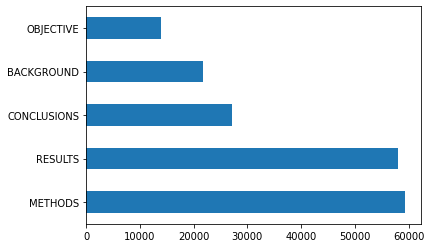

In [13]:
# Distribution of labels
train_df.target.value_counts(), train_df["target"].value_counts().plot(kind="barh")

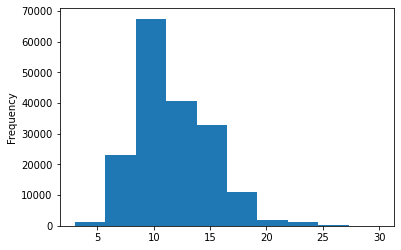

In [14]:
# Check the length of total lines
train_df.total_lines.plot(kind="hist");

### Get list of sentences

In [15]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

### Make numeric labels (ML models require numeric labels)

In [16]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf

# Sparse matrix is not supported in tensorflow!
one_hot_encoder = OneHotEncoder(sparse=False) # Default is true
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))

# Check what one hot encoded labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label encoded label

In [17]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_label_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [18]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

# Modelling various types of models
Start with building a baseline (TF-IDF Multinomial Naive Bayes classifier)

## Model 0: Getting a baseline

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB()),
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences, 
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [20]:
# Evaluate baseline model on validation 
model_0.score(X=val_sentences, 
              y=val_labels_encoded)

0.7218323844829869

In [21]:
# Make predictions using baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds.shape, val_labels_encoded.shape

((30212,), (30212,))

In [22]:
import sys
sys.path.append("../helper")
from helperFunctions import calculate_results

In [23]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [24]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Preparing the data (text) for deep sequence models
Before starting to build deeper models, we've got to create vecotrization and embedding layers

In [25]:
import numpy as np 
import tensorflow as tf
from tensorflow.keras import layers

In [26]:
train_sentences[:]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [27]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

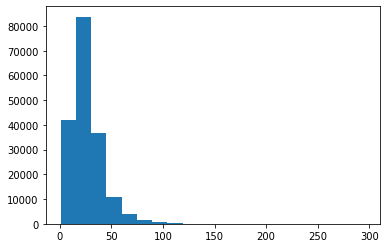

In [28]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20);

In [29]:
# How long of a sentence length covers 95% of the data
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [30]:
# Maximum sequence length in the training set
max(sent_lens)

296

### Create text vectorizer layer
Create a layer which maps text to numbers

In [31]:
# How many words are in the vocab? (taken from table 2 in: https://arxiv.org/pdf/1710.06071.pdf)
max_tokens = 68000

In [32]:
# Create text vectorizer
from keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in vocab
                                    output_sequence_length=output_seq_len) # desired output len of vectorized sequences

In [33]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [34]:
# Test out the text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence)}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
besides , no patients showed any symptoms of local anesthetic toxicity .

Length of text: 72

Vectorized text: [[4444   33   12  147  262  144    4  585 1610  997    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [35]:
# How many words in the training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Most common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [36]:
# Get the config of the text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

### Create customtext embedding

In [37]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                                  output_dim=128, # Note: bigger sizes result in more parameters to train and better accuracy
                                  mask_zero=True, # use masking to handle variable sequence lengths 
                                  name="token_embedding")

In [38]:
# Show example embedding
print(f"Sentence before vectorization:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
 besides , no patients showed any symptoms of local anesthetic toxicity .

Sentence after vectorization (before embedding):
 [[4444   33   12  147  262  144    4  585 1610  997    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding:
 [[[-0.00128137 -0.03747636 -0.00050533 ... -0.02439176  0.03001985
   -0.01114168]
  [ 0.04387825  0.01561565  0.00482932 ...  0.0152745   0.00863234
    0.03856326]
  [-0.04485495 -0.04368352 -0.0354353  ... -0.02447136 -0.03112055
    0.04108867]
  ...
  [-0.04138813 -0.00318635  0.02045026 ...  0.00718734 -0.01083839
   -0.03903686]
  [-0.04138813 -0.00318635  0.02045026 ...  0.00718734 -0.01083839
   -0.03903686]
  [-0.04138813 -0.00318635  0.02045026 ...  0.00718734 -0.01083839
   -0.03903686]]]

Embedded sentence shape:

## Creating datasets (making sure the data loads as fast as possible)
Setting up data to run as fast as possible with TensorFlow tf.data API
- https://www.tensorflow.org/guide/data_performance
- https://www.tensorflow.org/guide/data


In [39]:
# Turn the data into tensorflow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [40]:
# Take the TensorSliceDataset and turn them to prefetched datasets and batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # The order of sequences matter so no need to shuffle
valid_dataset = valid_data.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset


<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

# Model 1: Conv1D with token embeddings

In [41]:
# Create 1D conv model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # Vectorize text inputs (the sentence)
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of the feature vector from the conv layer
outputs = layers.Dense(num_classes, activation="softmax", name="output")(x)

model_1 = tf.keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [42]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 output (Dense)              (None, 5)                 325   

In [43]:
# Fit the Conv 1D model
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)), # use 10% of the train data to run experiments faster and see which architecture does work
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 14s 11ms/step - loss: 0.9215 - accuracy: 0.6361 - val_loss: 0.6971 - val_accuracy: 0.7334
Epoch 2/3
562/562 [==============================] - 6s 11ms/step - loss: 0.6671 - accuracy: 0.7527 - val_loss: 0.6415 - val_accuracy: 0.7670
Epoch 3/3
562/562 [==============================] - 6s 11ms/step - loss: 0.6249 - accuracy: 0.7707 - val_loss: 0.6022 - val_accuracy: 0.7822


In [44]:
# Evaluate on the whole validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 4ms/step - loss: 0.6043 - accuracy: 0.7835


[0.6043322086334229, 0.7834635376930237]

In [45]:
# Make predictions (our model predicts prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

(array([[4.2172691e-01, 1.8062291e-01, 7.4931785e-02, 2.9814750e-01,
         2.4570931e-02],
        [4.3863392e-01, 2.7668175e-01, 1.5377978e-02, 2.6062453e-01,
         8.6818300e-03],
        [1.5899406e-01, 8.9658871e-03, 2.1933943e-03, 8.2980311e-01,
         4.3598458e-05],
        ...,
        [3.6865788e-06, 7.9885911e-04, 7.3509262e-04, 3.1344453e-06,
         9.9845922e-01],
        [5.3057648e-02, 4.3213055e-01, 1.1487525e-01, 6.5383919e-02,
         3.3455262e-01],
        [1.6798836e-01, 7.0204842e-01, 3.4535371e-02, 4.9659703e-02,
         4.5768056e-02]], dtype=float32),
 (30212, 5))

In [46]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1], dtype=int64)>

In [47]:
# Calculate model_1_results
model_1_results = calculate_results(y_true=val_labels_encoded, 
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.34635244273798,
 'precision': 0.7806755548398395,
 'recall': 0.7834635244273799,
 'f1': 0.7806158098123591}

# Model 2: Feature extraction with pretrained token embeddings

In [48]:
# Pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [49]:
# Test out the pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]}\n")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")

Random sentence:
 we share experiences of formal ce for a paediatric randomized controlled malaria vaccine trial conducted in three sites within kilifi county , kenya .
Sentence after embedding:
[-0.04526775  0.04315782 -0.02524386 -0.05610225 -0.01169777  0.06477465
  0.02498199 -0.02057281  0.06444715 -0.06186689  0.0827696   0.0646398
  0.06722102  0.07344583  0.00916693  0.00420151 -0.08227304 -0.03653499
 -0.00016784  0.01556795 -0.02161727  0.01846697 -0.05077815  0.07998973
  0.0688803   0.05582926  0.02324963  0.05493553  0.04167511  0.06328633]

Length of sentence embedding: 512


In [50]:
# Define featuer extraction model using TF Hub Layer
inputs = layers.Input(shape=[], dtype=tf.string, name="input_layer")
pretrained_embedding = tf_hub_embedding_layer(inputs) # Tokenize text and create embedding of each sequence (512 long vector)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
outputs = layers.Dense(num_classes, activation="softmax")(x) # Dense above isn't necessary can add other layers to make it more complex
model_2 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_2_USE_feature_extractor")
model_2.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

In [51]:
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [52]:
# Fit pretrained model
history_model_2 = model_2.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 12s 17ms/step - loss: 0.9196 - accuracy: 0.6488 - val_loss: 0.7969 - val_accuracy: 0.6885
Epoch 2/3
562/562 [==============================] - 9s 16ms/step - loss: 0.7684 - accuracy: 0.7008 - val_loss: 0.7546 - val_accuracy: 0.7045
Epoch 3/3
562/562 [==============================] - 9s 16ms/step - loss: 0.7507 - accuracy: 0.7141 - val_loss: 0.7374 - val_accuracy: 0.7128


In [53]:
# Evaluate on the whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 14s 14ms/step - loss: 0.7396 - accuracy: 0.7136


[0.7395588159561157, 0.7136237025260925]

In [54]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

array([[0.39478073, 0.369548  , 0.00280902, 0.22355752, 0.00930474],
       [0.37492085, 0.46314412, 0.00372719, 0.1556362 , 0.00257165],
       [0.24235557, 0.12693359, 0.01656923, 0.5766651 , 0.03747647],
       ...,
       [0.0018466 , 0.00524515, 0.05295937, 0.00096813, 0.93898076],
       [0.00373331, 0.04535629, 0.2176041 , 0.00159582, 0.73171043],
       [0.17654978, 0.24095246, 0.5218638 , 0.00726404, 0.05336982]],
      dtype=float32)

In [55]:
# Convert the prediction probs found with feature extraction to labels
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2], dtype=int64)>

In [56]:
# Calculate results from TF Hub pretrained embeddings results
model_2_results = calculate_results(val_labels_encoded, model_2_preds)
model_2_results

{'accuracy': 71.36237256719184,
 'precision': 0.714244481926824,
 'recall': 0.7136237256719185,
 'f1': 0.7109142424179353}

In [57]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

# Model 3: Conv1D with character embeddings
This paper to replicate states that combination token and character-level embeddings.
Previously, token-level embeddings were performed. However, using similar steps character-embeddings can be performed

### Create a character-level tokenizer

In [58]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [59]:
# Function to split sentences into characters
def split_chars(text):
    return " ".join(list(text))

In [60]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [61]:
# Whats the average character length
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <BarContainer object of 7 artists>)

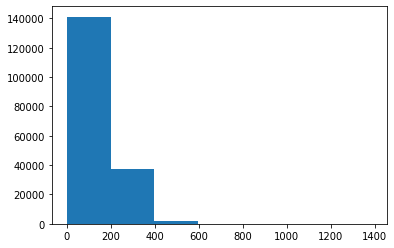

In [62]:
# Check the distribution of the character-level sequences
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7)

In [63]:
# Find char len that covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [64]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [65]:
# Create the text vectorization letters
NUM_CHAR_TOKENS = len(alphabet) + 2 # +2 for space and OOV (UNK in tensorflow)
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    name="char_vectorizer")


In [66]:
# Adapt to training character
char_vectorizer.adapt(train_chars)

In [67]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [68]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"Length of random_train_charsL {len(random_train_chars)}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"Vectorized chars:\n {vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")                                                                                                                                                                                                                                                                                                                                                    

Charified text:
 i n t e r f e r o n   (   i f n   )   -   ,   i l - @   ,   i l - @   a n d   p e r f o r i n   e l i s p o t   a s s a y s   p e r f o r m e d   a t   e a c h   t i m e   p o i n t   q u a n t i f i e d   f u n c t i o n a l   r e s p o n s e s   t o   g a g   p @ / p @   ,   n e f   ,   r e v   ,   a n d   t a t   p e p t i d e s   ;   a n d   d e t a i l e d   t - c e l l   i m m u n o p h e n o t y p i n g   w a s   u n d e r t a k e n   b y   f l o w   c y t o m e t r y   .
Length of random_train_charsL 483
Vectorized chars:
 [[ 4  6  3  2  8 17  2  8  7  6  4 17  6  4 12  4 12  5  6 10 14  2  8 17
   7  8  4  6  2 12  4  9 14  7  3  5  9  9  5 19  9 14  2  8 17  7  8 15
   2 10  5  3  2  5 11 13  3  4 15  2 14  7  4  6  3 26 16  5  6  3  4 17
   4  2 10 17 16  6 11  3  4  7  6  5 12  8  2  9 14  7  6  9  2  9  3  7
  18  5 18 14 14  6  2 17  8  2 21  5  6 10  3  5  3 14  2 14  3  4 10  2
   9  5  6 10 10  2  3  5  4 12  2 10  3 11  2 12 12  4 15 15 16  6  7 14
  

In [69]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=len(char_vocab), # number of different characters
                              output_dim=25, # this is the size of the embedding in the paper
                              mask_zero=True, 
                              name="char_embed")
char_embed

In [70]:
# Test our character embedding layer
print(f"Charified text:\n {random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars. (after vectorization and embedding):\n {char_embed_example}")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text:
 i n t e r f e r o n   (   i f n   )   -   ,   i l - @   ,   i l - @   a n d   p e r f o r i n   e l i s p o t   a s s a y s   p e r f o r m e d   a t   e a c h   t i m e   p o i n t   q u a n t i f i e d   f u n c t i o n a l   r e s p o n s e s   t o   g a g   p @ / p @   ,   n e f   ,   r e v   ,   a n d   t a t   p e p t i d e s   ;   a n d   d e t a i l e d   t - c e l l   i m m u n o p h e n o t y p i n g   w a s   u n d e r t a k e n   b y   f l o w   c y t o m e t r y   .

Embedded chars. (after vectorization and embedding):
 [[[ 2.6070643e-02  4.1232277e-02  4.2870630e-02 ...  8.9532621e-03
   -5.6218356e-05 -2.7883960e-02]
  [-7.9799071e-03 -4.1907322e-02  1.6088534e-02 ...  2.9628586e-02
    4.7096934e-02  1.2853812e-02]
  [-2.8555617e-03 -4.6717383e-02 -3.8612284e-02 ... -3.3770815e-02
    2.1070685e-02 -2.9104877e-02]
  ...
  [ 2.2403710e-03 -3.2224346e-02  1.4297161e-02 ...  4.9752209e-02
    2.7299527e-02  4.9065623e-02]
  [ 2.2403710e-03 -3.2224346e-02  

In [81]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1d_char_embeddings")

# Compile
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [72]:
model_3.summary()

Model: "model_3_conv1d_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_average_pooling1d_1   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 

In [76]:
# Create char level dataset
# Two parenthesis are necessary 
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [82]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1*len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 4s 7ms/step - loss: 1.2657 - accuracy: 0.4748 - val_loss: 1.1421 - val_accuracy: 0.5326
Epoch 2/3
562/562 [==============================] - 4s 6ms/step - loss: 1.0933 - accuracy: 0.5507 - val_loss: 1.0225 - val_accuracy: 0.5874
Epoch 3/3
562/562 [==============================] - 4s 6ms/step - loss: 0.9960 - accuracy: 0.6063 - val_loss: 0.9429 - val_accuracy: 0.6336


In [83]:
# Make predictions with the char only model
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

array([[0.19431664, 0.24398778, 0.12976204, 0.3966659 , 0.03526757],
       [0.1664381 , 0.5615995 , 0.01683177, 0.17843515, 0.0766954 ],
       [0.12532037, 0.51284283, 0.11433883, 0.1666108 , 0.08088706],
       ...,
       [0.03234196, 0.05041736, 0.21244109, 0.01479234, 0.6900072 ],
       [0.03744947, 0.10719122, 0.3794216 , 0.03067523, 0.4452625 ],
       [0.3877898 , 0.3721749 , 0.08472551, 0.13813642, 0.01717342]],
      dtype=float32)

In [84]:
# Convert probabilities to classes
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([3, 1, 1, ..., 4, 4, 0], dtype=int64)>

In [86]:
# Calculate the scores
model_3_results = calculate_results(val_labels_encoded, model_3_preds)
model_3_results

{'accuracy': 62.23354958294718,
 'precision': 0.6320867257446391,
 'recall': 0.6223354958294718,
 'f1': 0.6096163007296957}

# Model 4: Combining pretrained token embeddings + characters embeddings (hybrid)
1. Create a token-level embedding model (similar `model_1`)
2. Create a character-level model (similar to `model_3` with a slight modification)
3. Combine 1 & 2 with a concatenate (`layers.Concatenate`)
4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of https://arxiv.org/pdf/1612.05251.pdf
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as outputs

In [91]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) # Architecture like Fig one of the paper

char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                 char_model.output])

# 4. Create output layers - adding in Dropout, discussed in 4.2 of the paper
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [92]:
# Get a summary of our model
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

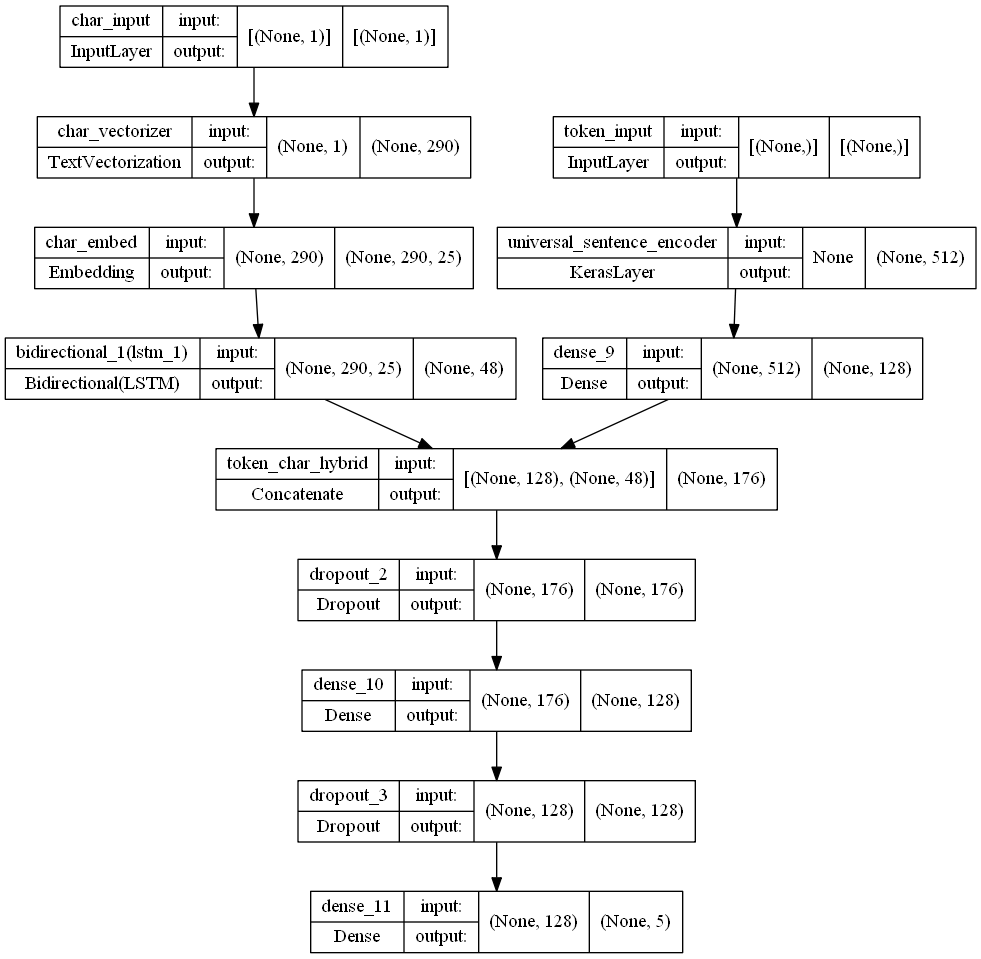

In [95]:
# Plot hybrid token and character model 
# Better represents more complex models than summary
from tensorflow.keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [96]:
# Compile the model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # The model in the papers uses SGD (section 4.2)
                metrics=["accuracy"])

### Combining token and characters into tf.data.Dataset

In [97]:
# Combine chars and tokens into a dataset
# Pipeline order matters and should align with how model was built!!!!
train_token_char_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_token_char_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [98]:
# Same steps for validation data
val_token_char_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars)) # make data
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot) # make labels
val_char_token_dataset = tf.data.Dataset.zip((val_token_char_data, val_char_token_labels)) # combine data and labels

# Prefetch and batch validation data 
# Also same for test data but will skip for now
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [99]:
# Check out the training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [100]:
# Fit the model
history_model_4 = model_4.fit((train_char_token_dataset),
                              epochs=3,
                              steps_per_epoch=int(0.1*len(train_char_token_dataset)),
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1*len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 51s 76ms/step - loss: 0.9901 - accuracy: 0.6041 - val_loss: 0.7823 - val_accuracy: 0.6948
Epoch 2/3
562/562 [==============================] - 39s 70ms/step - loss: 0.8024 - accuracy: 0.6872 - val_loss: 0.7163 - val_accuracy: 0.7271
Epoch 3/3
562/562 [==============================] - 35s 62ms/step - loss: 0.7771 - accuracy: 0.7032 - val_loss: 0.6956 - val_accuracy: 0.7350


In [101]:
# Evaluate the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 30s 31ms/step - loss: 0.7001 - accuracy: 0.7309


[0.7000789642333984, 0.7308685183525085]

In [102]:
# Make predictions using the token-charater model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

array([[4.4329005e-01, 3.4313625e-01, 3.7236956e-03, 2.0450157e-01,
        5.3484547e-03],
       [2.8143191e-01, 5.2996325e-01, 2.0137036e-03, 1.8527184e-01,
        1.3192584e-03],
       [3.2222736e-01, 1.7274505e-01, 4.6865977e-02, 4.2755422e-01,
        3.0607326e-02],
       ...,
       [4.5495506e-04, 8.9712404e-03, 4.7194514e-02, 1.7208436e-04,
        9.4320726e-01],
       [7.7039213e-03, 7.1657121e-02, 2.1999700e-01, 3.1097312e-03,
        6.9753224e-01],
       [3.4176570e-01, 4.0994766e-01, 1.7465729e-01, 2.3488231e-02,
        5.0141159e-02]], dtype=float32)

In [103]:
# Format the probs into labels 
model_4_pred = tf.argmax(model_4_pred_probs, axis=1)
model_4_pred

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1], dtype=int64)>

In [106]:
# Calculate the score of model 4 (hybrid)
model_4_results = calculate_results(val_labels_encoded,model_4_pred)
model_4_results

{'accuracy': 73.08685290613002,
 'precision': 0.7343366734469156,
 'recall': 0.7308685290613002,
 'f1': 0.7275943891187121}

# Model 5: Transfer learning Pretrained token embeddings + character embeddings + positional embeddings
Feature Engineering
- Take non-obvious information from the data and incorporate it in the model numerically to learn
- How to add extra layers to add those features?

In [107]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


Any engineered features used to train a model need to be available at test time. In this case, line numbers and total lines are available.

### Create positional embeddings

In [108]:
# How manty different line numbers are there?
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<AxesSubplot:ylabel='Frequency'>

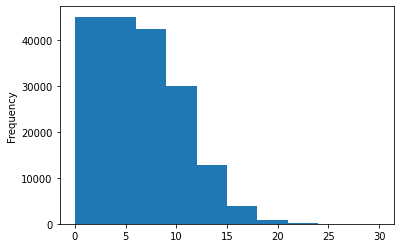

In [110]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist()

In [ ]:
# Use TensorFlow to create one-hot-encoded labels